# CEMA 2025 Internship Task Analysis
    
    This notebook analyzes HIV data, multidimensional poverty data, and child mortality data to create visualizations and identify trends.

## 2. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import requests
import io
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
warnings.filterwarnings('ignore')

# Set plotting style

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 3. Load Datasets

In [11]:
dataset_science_path = r"C:\Users\Amolo Washington\OneDrive\Desktop\CEMA_INTERNSHIP\dataset_datascience.csv"
hiv_data_path = r"C:\Users\Amolo Washington\OneDrive\Desktop\CEMA_INTERNSHIP\HIV data 2000-2023.csv"
poverty_data_path = r"C:\Users\Amolo Washington\OneDrive\Desktop\CEMA_INTERNSHIP\multidimensional_poverty.xlsx"
neonatal_data_path = r"C:\Users\Amolo Washington\OneDrive\Desktop\CEMA_INTERNSHIP\neonatal_mortality_rate.csv"
under5_data_path = r"C:\Users\Amolo Washington\OneDrive\Desktop\CEMA_INTERNSHIP\under_five mortality rate.csv"

### 3.1 Load Dataset Science

In [21]:
try:
    dataset_science = pd.read_csv(dataset_science_path)
    print(f"Dataset science loaded: {dataset_science.shape[0]} rows, {dataset_science.shape[1]} columns")
    dataset_science_loaded = True
except Exception as e:
    print(f"Error loading dataset_datascience.csv: {e}")
    dataset_science = None
    dataset_science_loaded = False

# Display the first few rows if loaded successfully\n",
if dataset_science_loaded:
    dataset_science.head(2)

Dataset science loaded: 129564 rows, 23 columns


### 3.2 Load HIV Data

In [22]:
encodings_to_try = ['latin1', 'cp1252', 'ISO-8859-1', 'utf-16', 'windows-1250', 'windows-1252']
hiv_data = None

for encoding in encodings_to_try:
    try:
        print(f"Trying to load HIV data with encoding: {encoding}")
        hiv_data = pd.read_csv(hiv_data_path, encoding=encoding)
        print(f"HIV data loaded successfully with encoding {encoding}: {hiv_data.shape[0]} rows, {hiv_data.shape[1]} columns")
        hiv_data_loaded = True
        break  # Exit the loop if successful
    except Exception as e:
        print(f"Failed with encoding {encoding}: {e}")

if not hiv_data_loaded:
    print("Could not load HIV data with any of the attempted encodings.")


Trying to load HIV data with encoding: latin1
HIV data loaded successfully with encoding latin1: 1552 rows, 11 columns


### 3.3 Load Poverty Data

In [23]:
try:
    # First try loading without specifying a sheet
    try:
        poverty_data = pd.read_excel(poverty_data_path, skiprows=1)
        print(f"Poverty data loaded: {poverty_data.shape[0]} rows, {poverty_data.shape[1]} columns")
        poverty_data_loaded = True
    except Exception as e:
        print(f"Error loading poverty data without sheet specification: {e}")
        
        # If that fails, try listing all sheets and load the first one
        try:
            xls = pd.ExcelFile(poverty_data_path)
            print(f"Available sheets in the Excel file: {xls.sheet_names}")
            poverty_data = pd.read_excel(poverty_data_path, sheet_name=0, skiprows=1)
            print(f"Poverty data loaded from first sheet: {poverty_data.shape[0]} rows, {poverty_data.shape[1]} columns")
            poverty_data_loaded = True
        except Exception as e2:
            print(f"Error loading poverty data from first sheet: {e2}")
            poverty_data = None
except Exception as e:
    print(f"Error loading poverty data: {e}")
    poverty_data = None


Poverty data loaded: 111 rows, 16 columns


### 3.4 Load Mortality Data

In [24]:
# Load under-five mortality rate data
try:
    under5_data = pd.read_csv(under5_data_path)
    print(f"Under-five mortality data loaded: {under5_data.shape[0]} rows, {under5_data.shape[1]} columns")
    under5_data_loaded = True
except Exception as e:
    print(f"Error loading under-five mortality data: {e}")
    under5_data = None


Under-five mortality data loaded: 44 rows, 44 columns


In [25]:
# Load neonatal mortality rate data
try:
    neonatal_data = pd.read_csv(neonatal_data_path)
    print(f"Neonatal mortality data loaded: {neonatal_data.shape[0]} rows, {neonatal_data.shape[1]} columns")
    neonatal_data_loaded = True
except Exception as e:
    print(f"Error loading neonatal mortality data: {e}")
    neonatal_data = None

Neonatal mortality data loaded: 34 rows, 44 columns


In [18]:
## Check if all datasets were loaded successfully - FIXED BOOLEAN CHECK
if not (hiv_data_loaded and poverty_data_loaded and under5_data_loaded and neonatal_data_loaded):
    print("\nWARNING: Some datasets failed to load. Please check the file paths and try again.")
    
    # Let's see what we can do with the datasets that did load
    print("\nProceeding with available datasets...")
else:
    print("\nAll datasets loaded successfully!")



All datasets loaded successfully!


## 4. HIV Data Analysis

### 4.1 Clean and Prepare HIV Data

In [31]:
if hiv_data_loaded:
    print("Cleaning and preparing HIV data...")
    
    # Check if 'Value' column exists
    if 'Value' in hiv_data.columns:
       # Extract numeric values from the 'Value' column
       # The values are in format like 320 000 [280 000 - 380 000]
       # We'll extract the first number
       # Function to extract the first number from a string
            def extract_first_number(value_str):
                if pd.isna(value_str):
                    return np.nan
                
                try:
                    # Remove brackets and their contents
                    value_str = str(value_str)
                    value_str = value_str.split('[')[0].strip()
                    # Remove spaces and convert to number
                    value_str = value_str.replace(' ', '')
                    return float(value_str)
                except:
                    return np.nan
            # Apply the function to create a new numeric column
            hiv_data['Value_numeric'] = hiv_data['Value'].apply(extract_first_number)
            print("Sample of extracted numeric values:")
            display(pd.DataFrame({
                'Original Value': hiv_data['Value'].head(5),
                'Extracted Numeric Value': hiv_data['Value_numeric'].head(5)
            }))
            # Check for the indicator of interest
            if 'Indicator' in hiv_data.columns:
                # Get unique indicators
                print("nUnique indicators in HIV data:")
                unique_indicators = hiv_data['Indicator'].unique()
                for i, indicator in enumerate(unique_indicators):
                    print(f"{i+1}. {indicator}")
                # Filter for people living with HIV
                hiv_indicator = 'Estimated number of people (all ages) living with HIV'
                if hiv_indicator in unique_indicators:
                    hiv_filtered = hiv_data[hiv_data['Indicator'] == hiv_indicator]
                    print(f"nFiltered data for '{hiv_indicator}': {hiv_filtered.shape[0]} rows")
                else:
                    print(f"nIndicator '{hiv_indicator}' not found in the data.")
                    # Use the first indicator as a fallback
                    hiv_indicator = unique_indicators[0]
                    hiv_filtered = hiv_data[hiv_data['Indicator'] == hiv_indicator]
                    print(f"Using '{hiv_indicator}' instead: {hiv_filtered.shape[0]} rows")
            else:
                print("'Indicator' column not found in HIV data.")
                hiv_filtered = hiv_data.copy()
    else:
        print("'Value' column not found in HIV data.")
        hiv_filtered = hiv_data.copy()
else:
    
    print("HIV data not loaded. Skipping HIV data analysis.")

Cleaning and preparing HIV data...
Sample of extracted numeric values:


,Original Value,Extracted Numeric Value
0,320 000 [280 000 - 380 000],320000.0
1,320 000 [280 000 - 380 000],320000.0
2,320 000 [280 000 - 380 000],320000.0
3,320 000 [280 000 - 370 000],320000.0
4,300 000 [260 000 - 350 000],300000.0


nUnique indicators in HIV data:
1. Estimated number of people (all ages) living with HIV
nFiltered data for 'Estimated number of people (all ages) living with HIV': 1552 rows


### 4.2 Global HIV Trends

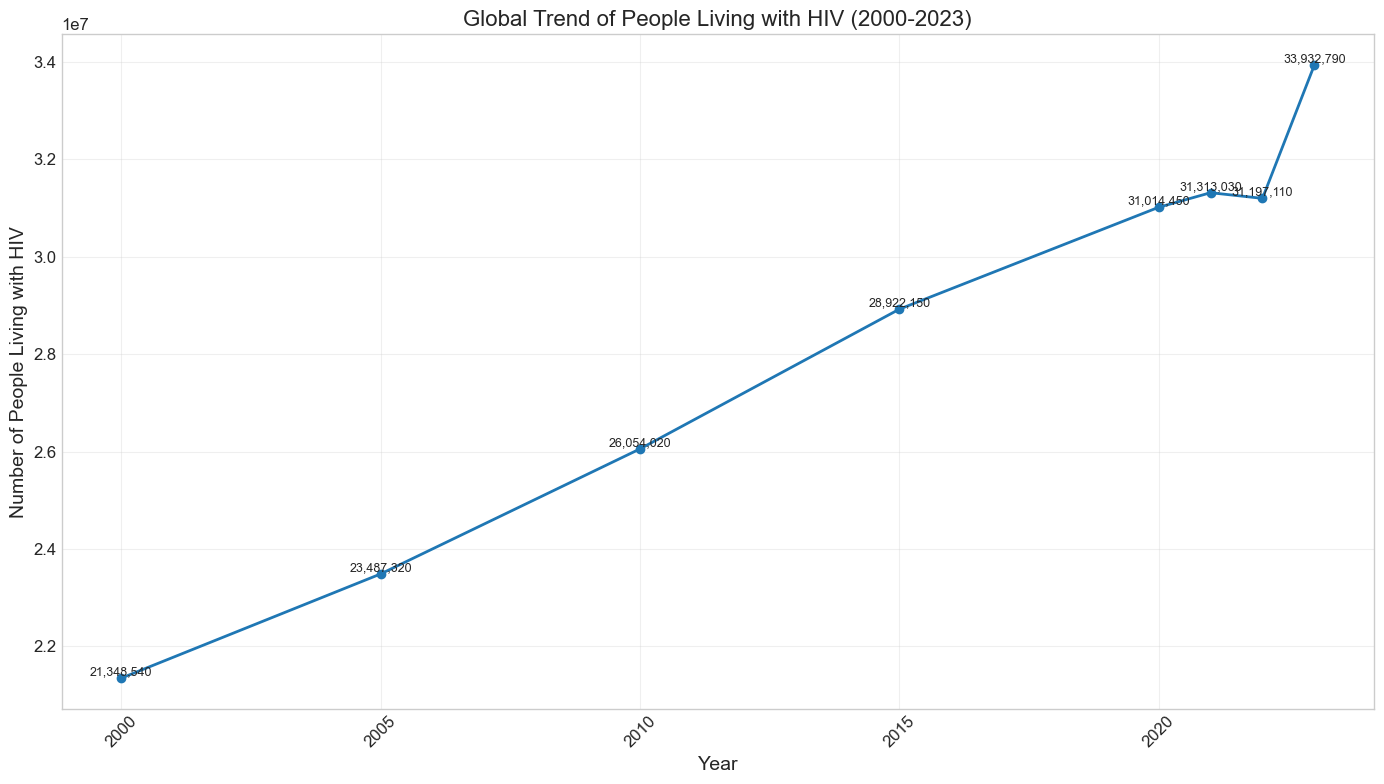

Global HIV totals by year:


,Period,Global_Total
0,2000,21348540.0
1,2005,23487320.0
2,2010,26054020.0
3,2015,28922150.0
4,2020,31014450.0
5,2021,31313030.0
6,2022,31197110.0
7,2023,33932790.0


In [32]:
if hiv_data_loaded and 'Value_numeric' in hiv_data.columns and 'Period' in hiv_data.columns:
        # Group by year to get global totals
        global_hiv_by_year = hiv_filtered.groupby('Period')['Value_numeric'].sum().reset_index()
        global_hiv_by_year = global_hiv_by_year.rename(columns={'Value_numeric': 'Global_Total'})

        # Plot global HIV trend
        plt.figure(figsize=(14, 8))
        plt.plot(global_hiv_by_year['Period'], global_hiv_by_year['Global_Total'],
                 marker='o', linewidth=2, color='#1f77b4')
        plt.title('Global Trend of People Living with HIV (2000-2023)', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Number of People Living with HIV', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)

        # Add data labels\n",
        for i, row in global_hiv_by_year.iterrows():
            plt.text(row['Period'], row['Global_Total'],
                     f"{row['Global_Total']:,.0f}",
                     ha='center', va='bottom', fontsize=9)
                     
        plt.tight_layout()
        plt.show()
        # Display the data
        print("Global HIV totals by year:")
        display(global_hiv_by_year)
else:
    print("Cannot create global HIV trends visualization due to missing data.")

### 4.3 Countries with Highest HIV Burden

Countries contributing to 75% of global HIV burden (13 countries):
['South Africa', 'India', 'Mozambique', 'Nigeria', 'United Republic of Tanzania', 'Uganda', 'Kenya', 'Zimbabwe', 'Zambia', 'Brazil', 'Malawi', 'Ethiopia', 'Thailand']


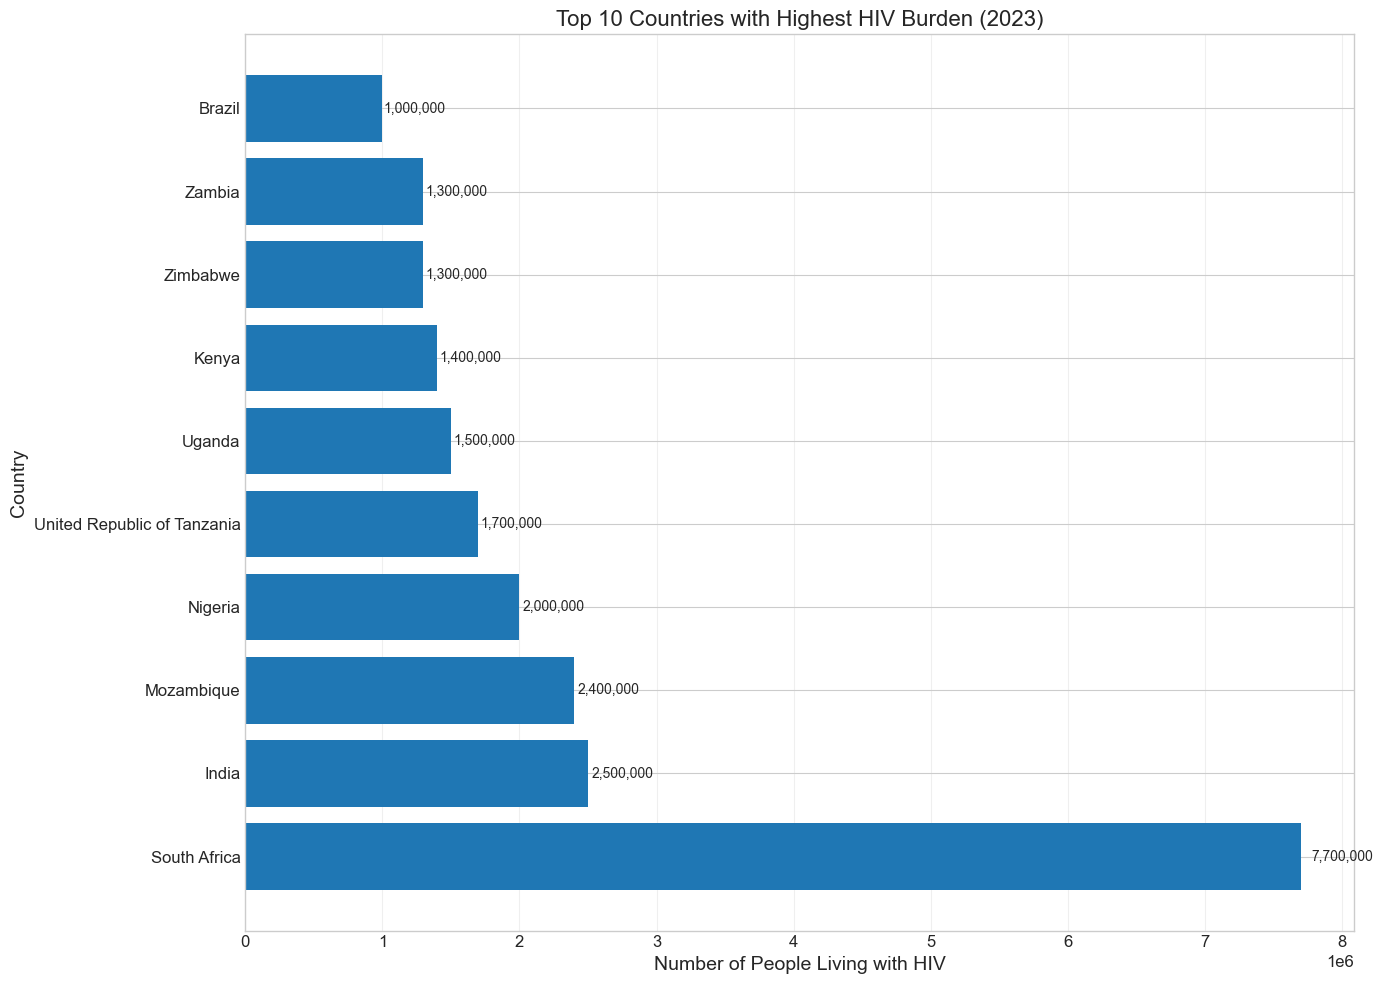

Top 10 countries with highest HIV burden (2023):


,Location,Value_numeric,Cumulative_Percentage
352,South Africa,7700000.0,22.691915
1272,India,2500000.0,30.059420
208,Mozambique,2400000.0,37.132225
256,Nigeria,2000000.0,43.026229
336,United Republic of Tanzania,1700000.0,48.036133
344,Uganda,1500000.0,52.456636
168,Kenya,1400000.0,56.582438
368,Zimbabwe,1300000.0,60.413541
360,Zambia,1300000.0,64.244644
416,Brazil,1000000.0,67.191646


In [33]:
if hiv_data_loaded and 'Value_numeric' in hiv_data.columns and 'Location' in hiv_data.columns:
        # Get the latest year data
        latest_year = hiv_filtered['Period'].max()
        latest_year_data = hiv_filtered[hiv_filtered['Period'] == latest_year]
    
        # Sort countries by HIV burden\n",
        latest_year_data = latest_year_data.sort_values('Value_numeric', ascending=False)
    
        # Calculate cumulative percentage\n",
        latest_year_data['Cumulative_Sum'] = latest_year_data['Value_numeric'].cumsum()
        latest_year_data['Global_Total'] = latest_year_data['Value_numeric'].sum()
        latest_year_data['Cumulative_Percentage'] = (latest_year_data['Cumulative_Sum'] / latest_year_data['Global_Total']) * 100
    
        # Identify countries contributing to 75% of global burden
        top_countries = latest_year_data[latest_year_data['Cumulative_Percentage'] <= 75]['Location'].tolist()
        print(f"Countries contributing to 75% of global HIV burden ({len(top_countries)} countries):")
        print(top_countries)
              
        # Plot top 10 countries
        top_10_countries = latest_year_data.head(10)
        plt.figure(figsize=(14, 10))
        bars = plt.barh(top_10_countries['Location'], top_10_countries['Value_numeric'], color='#1f77b4')
        plt.title(f'Top 10 Countries with Highest HIV Burden ({latest_year})', fontsize=16)
        plt.xlabel('Number of People Living with HIV', fontsize=14)
        plt.ylabel('Country', fontsize=14)
        plt.grid(True, alpha=0.3, axis='x')

        # Add data labels
        for bar in bars:
            width = bar.get_width()
            plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                     f"{width:,.0f}", va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Display the data for top countries
        print(f"Top 10 countries with highest HIV burden ({latest_year}):")
        display(top_10_countries[['Location', 'Value_numeric', 'Cumulative_Percentage']])
else:
    print("Cannot create countries with highest HIV burden visualization due to missing data.")

### 4.4 HIV Trends by Region

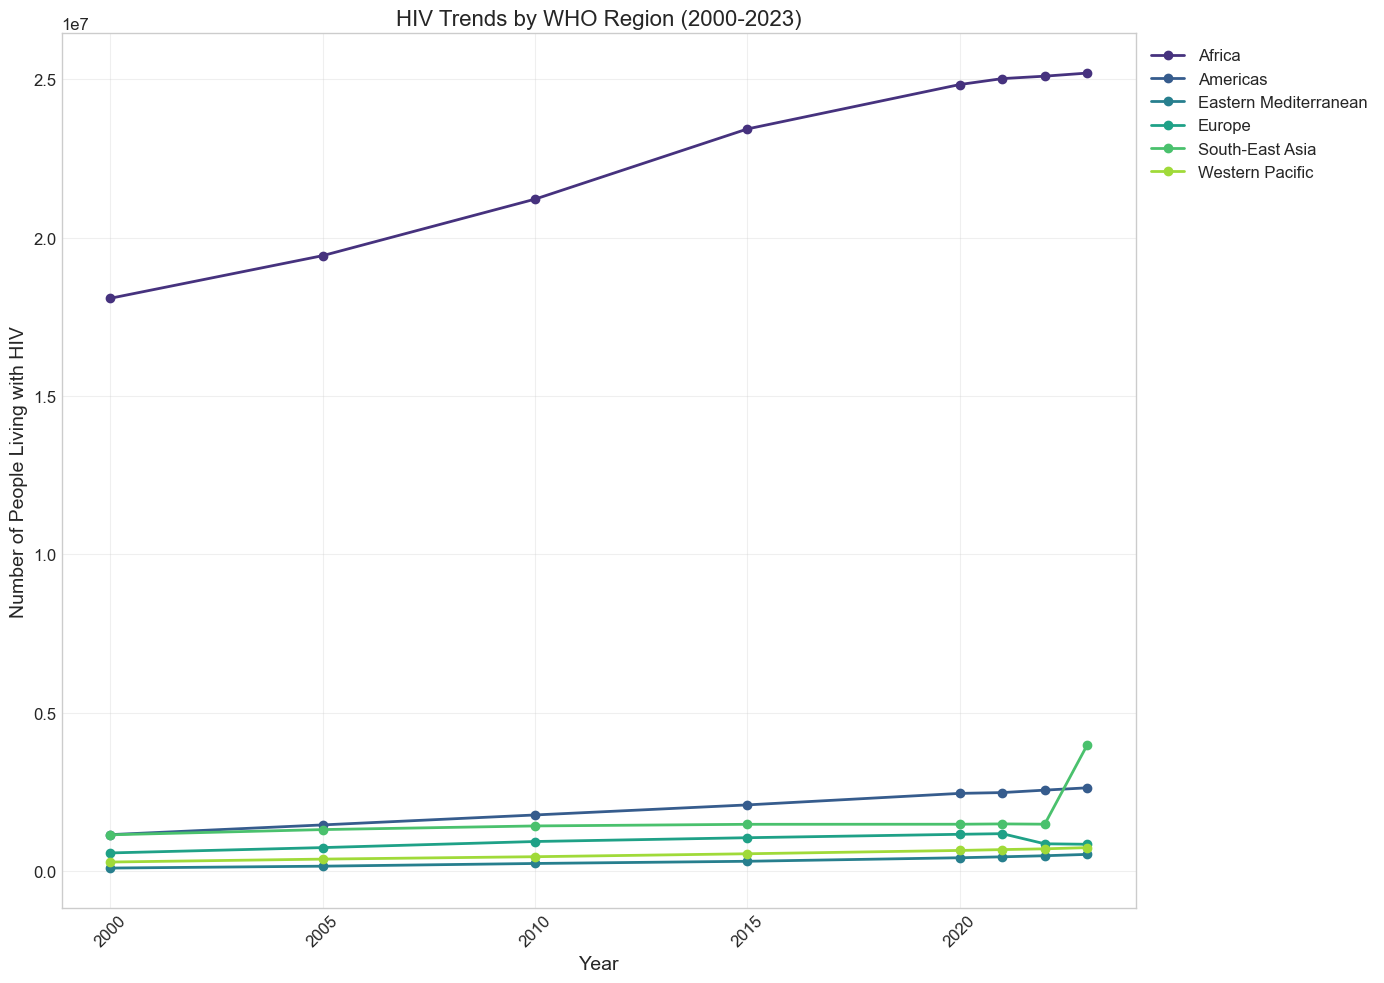

HIV totals by region and year:


ParentLocation,Africa,Americas,Eastern Mediterranean,Europe,South-East Asia,Western Pacific
Period,,,,,,
2000,18088900.0,1152900.0,97100.0,574850.0,1147090.0,287700.0
2005,19435000.0,1459800.0,156640.0,743650.0,1312330.0,379900.0
2010,21219600.0,1773900.0,242070.0,935570.0,1427320.0,455560.0
2015,23436000.0,2091600.0,311670.0,1055380.0,1478780.0,548720.0
2020,24837900.0,2455300.0,422730.0,1163600.0,1481300.0,653620.0
2021,25025000.0,2480700.0,452150.0,1183640.0,1491400.0,680140.0
2022,25102100.0,2558000.0,486170.0,863690.0,1482600.0,704550.0
2023,25199400.0,2631200.0,529280.0,848240.0,3982700.0,741970.0


In [35]:
if hiv_data_loaded and 'ParentLocation' in hiv_data.columns:
        # Group by region and year
        region_hiv_by_year = hiv_filtered.groupby(['ParentLocation', 'Period'])['Value_numeric'].sum().reset_index()

        # Get unique regions
        regions = region_hiv_by_year['ParentLocation'].unique()

        # Plot HIV trends by region
        plt.figure(figsize=(14, 10))

        for region in regions:
            if pd.notna(region):  # Skip NaN regions
                region_data = region_hiv_by_year[region_hiv_by_year['ParentLocation'] == region]
                plt.plot(region_data['Period'], region_data['Value_numeric'],
                         marker='o', linewidth=2, label=region)
                
        plt.title('HIV Trends by WHO Region (2000-2023)', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Number of People Living with HIV', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Display the data
        print("HIV totals by region and year:")

        # Pivot the data for better display
        region_pivot = region_hiv_by_year.pivot(index='Period', columns='ParentLocation', values='Value_numeric')
        display(region_pivot)
else:
     print("Cannot create HIV trends by region visualization due to missing data.")

## 5. Child Mortality Analysis

### 5.1 Explore Mortality Data Structure

In [36]:
if under5_data_loaded and neonatal_data_loaded:
        # Check available geographic areas
        print("Available geographic areas in under-five mortality data:")
        print(under5_data['Geographic area'].unique())
        print("Available geographic areas in neonatal mortality data:")
        print(neonatal_data['Geographic area'].unique())
              
        # Check time periods available
        print("Time periods in under-five mortality data:")
        print(sorted(under5_data['TIME_PERIOD'].unique()))
        print("Time periods in neonatal mortality data:")
        print(sorted(neonatal_data['TIME_PERIOD'].unique()))
              
        # Check if we have Sub-Saharan Africa data
        if 'Sub-Saharan Africa' in under5_data['Geographic area'].values:
            print("Sub-Saharan Africa data is available. We'll analyze regional trends.")
        else:
            print("No Sub-Saharan Africa data found.")
else:
    print("Mortality data not loaded. Skipping mortality data exploration.")

Available geographic areas in under-five mortality data:
['Sub-Saharan Africa']
Available geographic areas in neonatal mortality data:
['Sub-Saharan Africa']
Time periods in under-five mortality data:
['1980-06', '1981-06', '1982-06', '1983-06', '1984-06', '1985-06', '1986-06', '1987-06', '1988-06', '1989-06', '1990-06', '1991-06', '1992-06', '1993-06', '1994-06', '1995-06', '1996-06', '1997-06', '1998-06', '1999-06', '2000-06', '2001-06', '2002-06', '2003-06', '2004-06', '2005-06', '2006-06', '2007-06', '2008-06', '2009-06', '2010-06', '2011-06', '2012-06', '2013-06', '2014-06', '2015-06', '2016-06', '2017-06', '2018-06', '2019-06', '2020-06', '2021-06', '2022-06', '2023-06']
Time periods in neonatal mortality data:
['1990-06', '1991-06', '1992-06', '1993-06', '1994-06', '1995-06', '1996-06', '1997-06', '1998-06', '1999-06', '2000-06', '2001-06', '2002-06', '2003-06', '2004-06', '2005-06', '2006-06', '2007-06', '2008-06', '2009-06', '2010-06', '2011-06', '2012-06', '2013-06', '2014-06

In [19]:
# Display the first few rows of each dataset to understand their structure
if hiv_data_loaded:
    print("\nExploring HIV data structure:")
    print(hiv_data.head(2))
    print("\nHIV data columns:", hiv_data.columns.tolist())

if poverty_data_loaded:
    print("\nExploring poverty data structure:")
    print(poverty_data.head(2))
    print("\nPoverty data columns:", poverty_data.columns.tolist())

if under5_data_loaded:
    print("\nExploring under-five mortality data structure:")
    print(under5_data.head(2))
    print("\nUnder-five mortality data columns:", under5_data.columns.tolist())

if neonatal_data_loaded:
    print("\nExploring neonatal mortality data structure:")
    print(neonatal_data.head(2))
    print("\nNeonatal mortality data columns:", neonatal_data.columns.tolist())



Exploring HIV data structure:
    IndicatorCode                                          Indicator  \
0  HIV_0000000001  Estimated number of people (all ages) living w...   
1  HIV_0000000001  Estimated number of people (all ages) living w...   

  ValueType ParentLocationCode ParentLocation Location type  \
0   numeric                AFR         Africa       Country   
1   numeric                AFR         Africa       Country   

  SpatialDimValueCode Location Period type  Period  \
0                 AGO   Angola        Year    2023   
1                 AGO   Angola        Year    2022   

                         Value  
0  320 000 [280 000 - 380 000]  
1  320 000 [280 000 - 380 000]  

HIV data columns: ['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode', 'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location', 'Period type', 'Period', 'Value']

Exploring poverty data structure:
  Region Country code Economy  Reporting year Survey name  Survey year  \
0 